## Лабораторная работа №5
### Выполнила Прудникова А. А.  М8О-408Б-20
#### Вариант 4


Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением. Исследовать зависимость погрешности от сеточных параметров.

In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import sys
import ipywidgets as widgets
import warnings

from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact
from IPython.display import display

In [20]:
# Функции условий и аналитического решения
def phi_0(t, a = 1.0):
    return math.exp(-a*t)

def phi_l(t, a = 1.0):
    return -math.exp(-a*t)

def u_0(x):
    return math.sin(x)


def u(x, t, a = 1.0):
    return math.exp(-a*t)*math.sin(x)

In [21]:
class Schema:
    def __init__(self, a = 1, f0 = phi_0, fl = phi_l, u0 = u_0, 
                 O = 0.5, l0 = 0, l1 = math.pi, T = 5, aprx_cls = None):
        self.fl = lambda t: fl(t, a)
        self.f0 = lambda t: f0(t, a)
        self.u0 = u0
        self.T = T
        self.l0 = l0
        self.l1 = l1
        self.tau = None
        self.h = None
        self.a = a
        self.O = O
        self.approx = None
        if aprx_cls is not None:
            self._init_approx(aprx_cls)
        self.sigma = None
        
    def _init_approx(self, a_cls):
        self.approx = a_cls(self.f0, self.fl)
    
    def set_approx(self, aprx_cls):
        self._init_approx(self, aprx_cls)
        
    def set_l0_l1(self, l0, l1):
        self.l0 = l0
        self.l1 = l1
        
    def set_T(self, T):
        self.T = T
        
    def compute_h(self, N):
        self.h = (self.l1 - self.l0) / N
        
    def compute_tau(self, K):
        self.tau = self.T / K
        
    def compute_sigma(self):
        self.sigma = self.a * self.tau / (self.h * self.h)
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
        
    def compute_line(self, t, x, last_line):
        pass
    
    def __call__(self, N=30, K=110):
        N, K = N-1, K-1
        self.compute_tau(K)
        self.compute_h(N)
        self.compute_sigma()
        ans = []
        x = list(self.nparange(self.l0, self.l1, self.h))
        last_line = list(map(self.u0, x))
        ans.append(list(last_line))
        X = []
        Y = []
        X.append(x)
        Y.append([0.0 for _ in x])
        for t in self.nparange(self.tau, self.T, self.tau):
            ans.append(self.compute_line(t, x, last_line))
            X.append(x)
            Y.append([t for _ in x])
            last_line = ans[-1]
        return X, Y, ans

Класс Schema представляет собой схему для аппроксимации уравнения теплопроводности на прямоугольной области (0, l0) x (0, l1) во временном интервале [0, T].

Аргументы конструктора класса:
- a - коэффициент теплопроводности
- f0 - начальное условие (функция f0(t))
- fl - граничное условие (функция fl(t))
- u0 - значение на границе x = 0 (функция u0(x))
- O - параметр аппроксимации
- l0 - начальное значение x
- l1 - конечное значение x
- T - конечное время
- aprx_cls - класс, используемый для аппроксимации (если указан, то будет использован данный класс)

Доступные методы класса:
- set_approx(aprx_cls) - установка класса аппроксимации
- set_l0_l1(l0, l1) - установка начального и конечного значения x
- set_T(T) - установка конечного времени
- __ call __ (N, K) - выполнение аппроксимации сеткой размером (N, K)

### Явная конечно-разностная схема

In [22]:
class Explict_Schema(Schema):
    def compute_sigma(self):
        self.sigma = self.a * self.tau / (self.h * self.h)
        if self.sigma > 0.5:
            warnings.warn("Sigma > 0.5")
        
    def compute_line(self, t, x, last_line):
        line = [None for _ in last_line]
        for i in range(1, len(x) - 1):
            line[i] = self.sigma*last_line[i-1] 
            line[i] += (1 - 2*self.sigma)*last_line[i]
            line[i] += self.sigma*last_line[i+1]
        line[0] = self.approx.explict_0(t, self.h, self.sigma, 
                                        last_line, line, t - self.tau)
        line[-1] = self.approx.explict_l(t, self.h, self.sigma, 
                                         last_line, line, t - self.tau)
        return line

### Схема Кранка-Николсона


In [23]:
class ExplicitImplicit(Schema):
    def set_O(self, O):
        self.O = O

    @staticmethod
    def race_method(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]

        P[0] /= A[0][1]
        Q[0] /= A[0][1]

        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z

        x = [item for item in Q]

        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]

        return x

    def compute_line(self, t, x, last_line):
        a = self.sigma * self.O
        b = -1 - 2 * self.sigma * self.O

        A = [(a, b, a) for _ in range(1, len(x)-1)]
        w = [-(last_line[i] + (1 - self.O) * self.sigma * (last_line[i-1] - 2*last_line[i] + last_line[i+1])) for i in range(1, len(x)-1)]

        koeffs = self.approx.nikolson_0(t, self.h, self.sigma, last_line, self.O, t - self.tau)
        A.insert(0, koeffs[:-1])
        w.insert(0, koeffs[-1])
        koeffs = self.approx.nikolson_l(t, self.h, self.sigma, last_line, self.O, t - self.tau)
        A.append(koeffs[:-1])
        w.append(koeffs[-1])

        return self.race_method(A, w)

class Interpolation:
    def __init__(self, f0, fl):
        self.f0 = f0
        self.fl = fl

    def explicit_0(self, t, h, sigma, l0, l1, t0):
        pass

    def explicit_l(self, t, h, sigma, l0, l1, t0):
        pass

    def nikolson_0(self, t, h, sigma, l0, O, t0):
        pass

    def nikolson_l(self, t, h, sigma, l0, O, t0):
        pass

# Здесь описаны разные варианты аппроксимации

class InterpolationTwoOne(Interpolation):
    def explicit_0(self, t, h, sigma, l0, l1, t0):
        return -h * self.f0(t) + l1[1]

    def explicit_l(self, t, h, sigma, l0, l1, t0):
        return h * self.fl(t) + l1[-2]

    def nikolson_0(self, t, h, sigma, l0, O, t0):
        return 0, -1, 1, h*self.f0(t)

    def nikolson_l(self, t, h, sigma, l0, O, t0):
        return -1, 1, 0, h*self.fl(t)

class InterpolationThreeTwo(Interpolation):
    def explicit_0(self, t, h, sigma, l0, l1, t0):
        return (-2*h*self.f0(t) + 4*l1[1] - l1[2]) / 3

    def explicit_l(self, t, h, sigma, l0, l1, t0):
        return (2*h*self.fl(t) + 4*l1[-2] - l1[-3]) / 3

    def nikolson_0(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.f0(t)
        d -= l0[1] + (1 - O)*sigma*(l0[0] - 2*l0[1] + l0[2])
        return 0, -2*sigma*O, 2*sigma*O - 1, d

    def nikolson_l(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.fl(t)
        d += l0[-2] + (1 - O)*sigma*(l0[-3] - 2*l0[-2] + l0[-1])
        return 1 - 2*sigma*O, 2*sigma*O, 0, d

class InterpolationTwoTwo(Interpolation):
    def explicit_0(self, t, h, sigma, l0, l1, t0):
        return -2*sigma*h*self.f0(t0) + \
                    2*sigma*l0[1] + (1 - 2*sigma)*l0[0]

    def explicit_l(self, t, h, sigma, l0, l1, t0):
        return 2*sigma*h*self.fl(t0) + \
                    2*sigma*l0[-2] + (1 - 2*sigma)*l0[-1]

    def nikolson_0(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.f0(t) - l0[0]
        d -= 2*(1 - O)*sigma*(l0[1] - l0[0] - h*self.f0(t0))
        return 0, -(2*sigma*O + 1), 2*sigma*O, d

    def nikolson_l(self, t, h, sigma, l0, O, t0):
        d = -2*sigma*O*h*self.fl(t) - l0[-1]
        d -= 2*(1 - O)*sigma*(l0[-2] - l0[-1] + h*self.fl(t0))
        return 2*sigma*O, -(2*sigma*O + 1), 0, d


In [24]:
def epsilon(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            ans += (z[i][j] - f(x[i][j], y[i][j]))**2
    return ans**0.5

def get_graphic_h(solver, real_f):
    h = []
    e = []
    for N in range(3, 50):
        x, y, z = solver(N)
        h.append(solver.h)
        e.append(epsilon(x, y, z, real_f))
    return h, e

In [25]:
explicit_implicit = ExplicitImplicit(T=1, aprx_cls=InterpolationTwoTwo)
krank_nikolson = ExplicitImplicit(T=1, aprx_cls=InterpolationTwoTwo, O=1)
krank = ExplicitImplicit(T=1, aprx_cls=InterpolationTwoTwo)

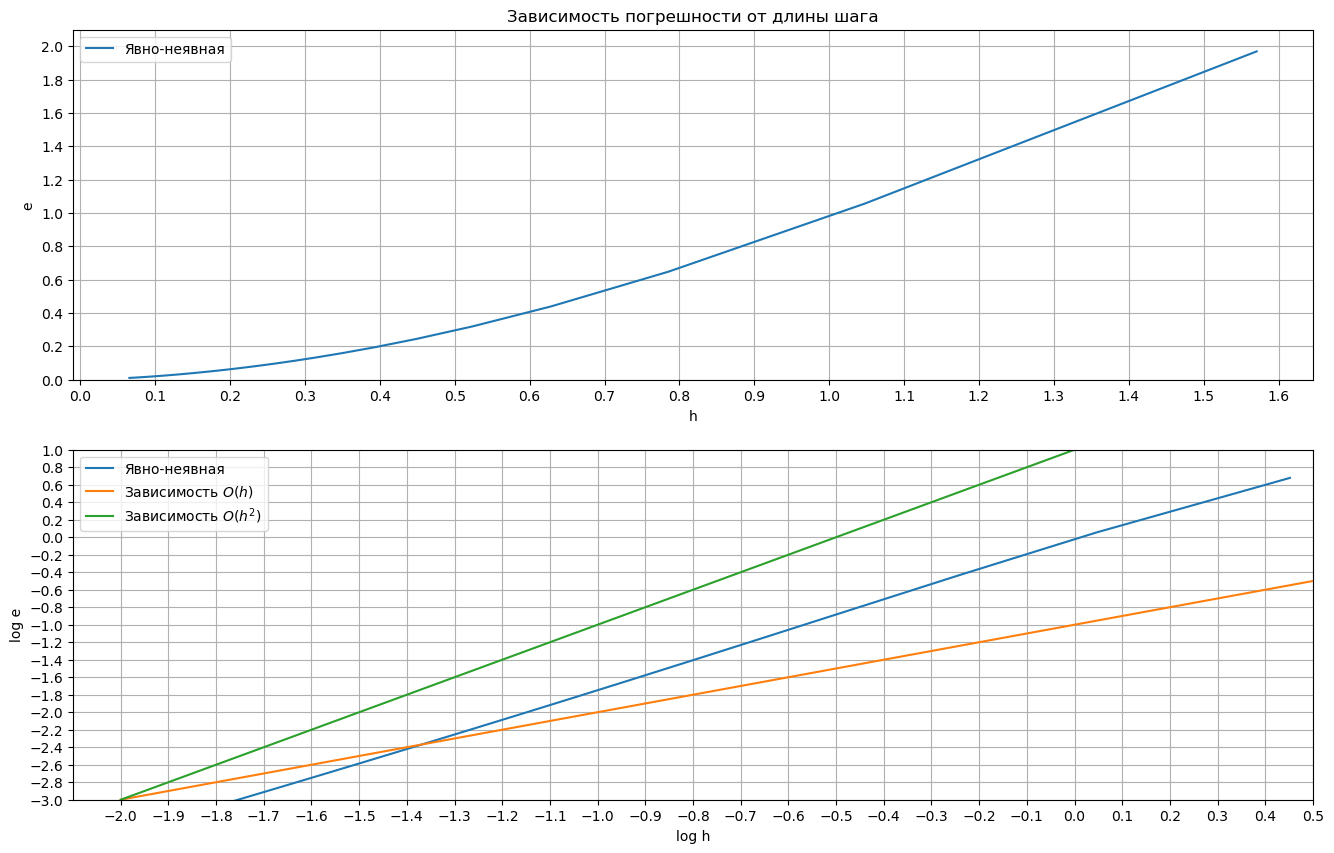

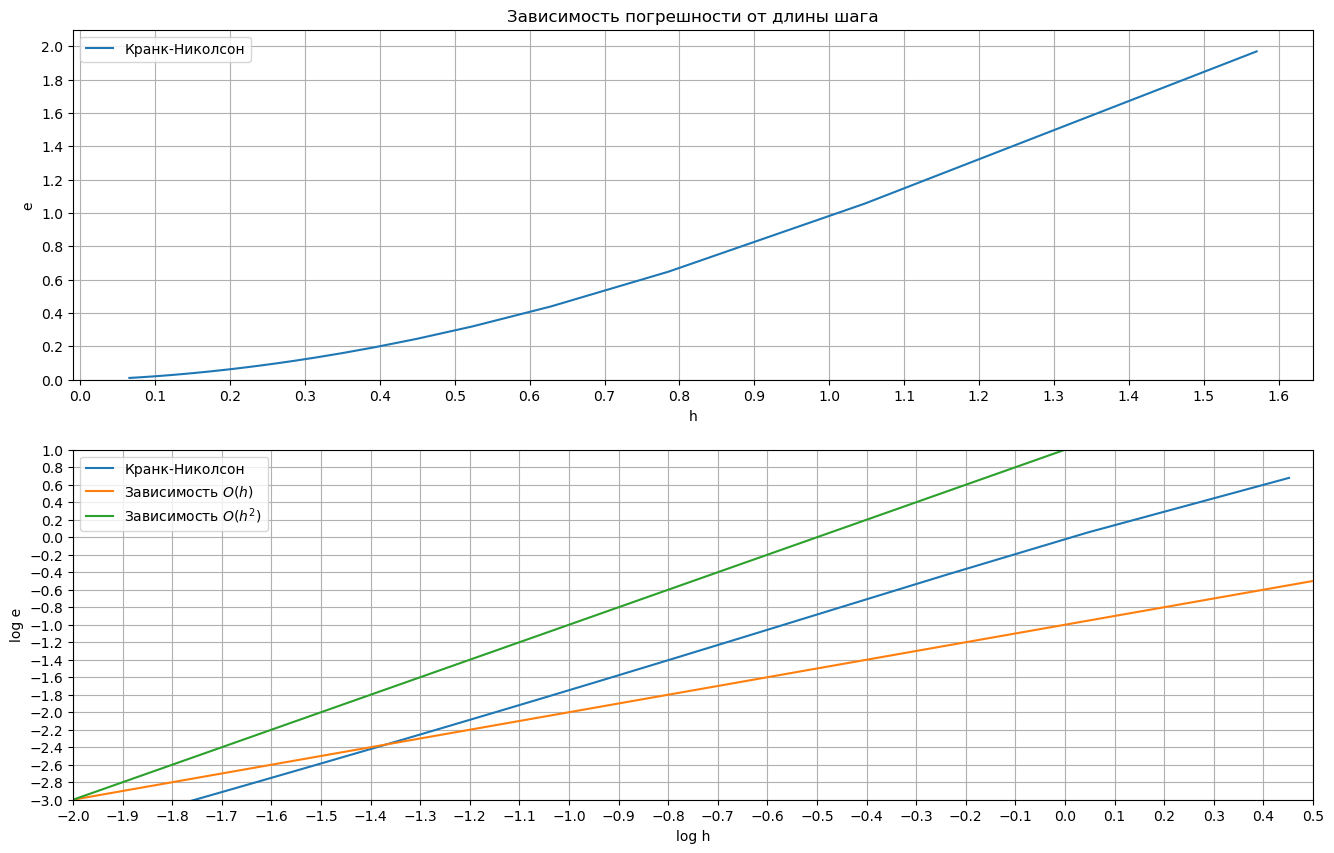

In [26]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(explicit_implicit, u)

plt.plot(h, e, label="Явно-неявная")
plt.xlabel("h")
plt.ylabel("e")
plt.ylim([0, 2.1])
plt.xticks(list(explicit_implicit.nparange(0, 1.6, 0.1)))
plt.yticks(list(explicit_implicit.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)

plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Явно-неявная")
plt.plot([-2, 0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-2, 0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.ylim([-3, 1])
plt.xlim([-2.1, 0.5])
plt.xticks(list(explicit_implicit.nparange(-2, 0.5, 0.1)))
plt.yticks(list(explicit_implicit.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(krank, u)

plt.plot(h, e, label="Кранк-Николсон")
plt.xlabel("h")
plt.ylabel("e")
plt.ylim([0, 2.1])
plt.xticks(list(krank.nparange(0, 1.6, 0.1)))
plt.yticks(list(krank.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Кранк-Николсон")
plt.plot([-2, 0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-2, 0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.ylim([-3, 1])
plt.xlim([-2, 0.5])
plt.xticks(list(krank.nparange(-2, 0.5, 0.1)))
plt.yticks(list(krank.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

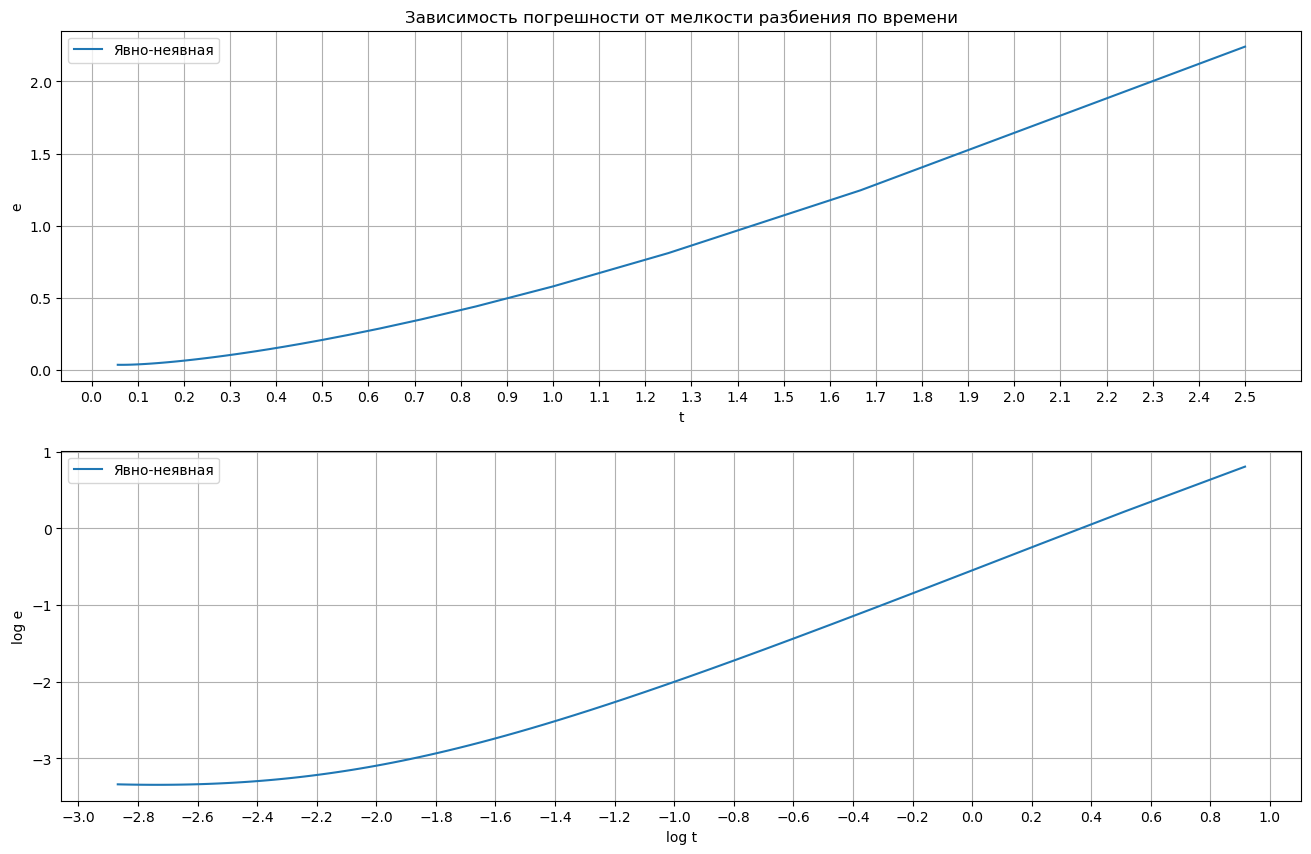

In [27]:
def get_graphic_tau(solver, real_f):
    tau = []
    e = []
    for K in range(3, 90):
        x, y, z = solver(K=K)
        tau.append(solver.tau)
        e.append(epsilon(x, y, z, real_f))
    return tau, e

explicit_implicit = ExplicitImplicit(T=5, aprx_cls=InterpolationTwoTwo)

plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(explicit_implicit, u)

plt.plot(tau, e, label="Явно-неявная")
plt.xlabel("t")
plt.ylabel("e")
plt.xticks(list(explicit_implicit.nparange(0, 2.5, 0.1)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Явно-неявная")
plt.xlabel("log t")
plt.ylabel("log e")

plt.xticks(list(explicit_implicit.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()